# Test MODFLOW New Style

## Packages

In [1]:
from pathlib import Path

import flopy
import pastas as ps

from pastas_plugins import modflow as ppmf

bindir = Path("bin")
if not (bindir / "mf6").exists():
    bindir.mkdir(parents=True, exist_ok=True)
    flopy.utils.get_modflow(bindir, repo="modflow6")

## Load Data

In [2]:
ds = ps.load_dataset("collenteur_2019")
head = ds["head"].squeeze().dropna()
prec = ds["rain"].squeeze().dropna().resample("D").asfreq().fillna(0.0)
evap = ds["evap"].squeeze().dropna()

## Test

### Pastas Model

In [3]:
ml = ps.Model(head, name="pastas")
rm = ps.RechargeModel(prec, evap, rfunc=ps.Exponential(), name="rch")
ml.add_stressmodel(rm)
ml.solve()

Fit report pastas                 Fit Statistics
nfev    11                     EVP         87.10
nobs    5737                   R2           0.87
noise   False                  RMSE         0.42
tmin    2003-01-01 00:00:00    AICc     -9870.13
tmax    2018-12-25 00:00:00    BIC      -9843.52
freq    D                      Obj        512.71
warmup  3650 days 00:00:00     ___              
solver  LeastSquares           Interp.        No

Parameters (4 optimized)
               optimal    initial  vary
rch_A       331.311198  29.925748  True
rch_a        98.430975  10.000000  True
rch_f        -0.854493  -1.000000  True
constant_d  -14.150486 -11.740288  True


<Axes: xlabel='Date', ylabel='Head'>

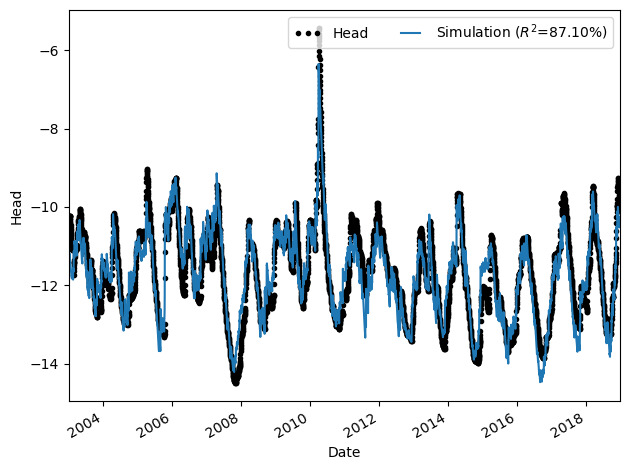

In [4]:
ml.plot()

### Pastas Model with MODFLOW plugin

In [5]:
ml = ps.Model(head, name="mftest")
mfml = ppmf.ModflowModel(
    model=ml,
    exe_name=bindir / "mf6",
    sim_ws=Path("mftest"),
    silent=True,
)
rch = ppmf.ModflowRch(prec, evap)
ghb = ppmf.ModflowGhb()
mfml.add_modflow_package([rch, ghb])
# ml.add_stressmodel(mfml)
# ml.simulate(p=ml.parameters.initial.values)
ml.solve()

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.Stressmodel mfsm has no rfunc


Fit report mftest                 Fit Statistics
nfev    17                     EVP         85.43
nobs    5737                   R2           0.85
noise   False                  RMSE         0.45
tmin    2003-01-01 00:00:00    AICc     -9172.65
tmax    2018-12-25 00:00:00    BIC      -9146.04
freq    D                      Obj        578.99
warmup  3650 days 00:00:00     ___              
solver  LeastSquares           Interp.        No

Parameters (4 optimized)
          optimal    initial   vary
mfsm_d -13.291330 -11.740288   True
mfsm_H   1.000000   1.000000  False
mfsm_S   0.359779   0.100000   True
mfsm_f  -1.223412  -1.000000   True
mfsm_C   0.003392   0.001000   True

Warnings! (2)
Response tmax for 'mfsm' > than calibration period.
Response tmax for 'mfsm' > than warmup period.


<Axes: xlabel='Date', ylabel='Head'>

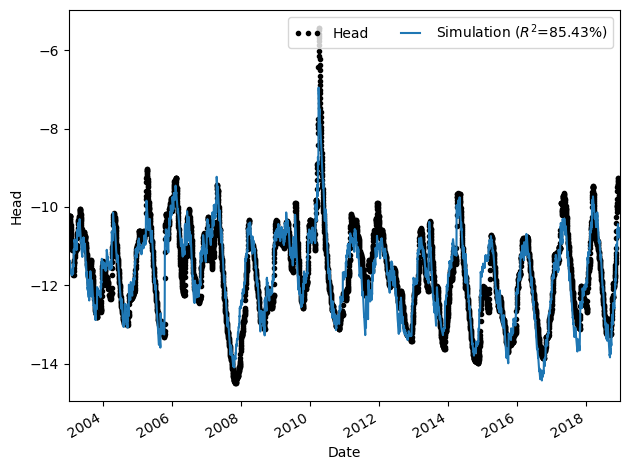

In [6]:
ml.plot()